<a href="https://colab.research.google.com/github/hammaad2002/Solar-Irradiance-Forecasting-Using-Deep-Learning-Techniques/blob/main/Solar_Irradiance_Forecasting_(comparison_between_RNN%2C_GRU%2C_LSTM%2C_TCN).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%%capture
!git clone https://github.com/hammaad2002/Solar-Irradiance-Forecasting.git
!pip install keras-tcn --no-dependencies

In [ ]:
from tcn import TCN
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from sklearn.metrics import mean_squared_error, r2_score
import math
from tqdm.notebook import tqdm
import random
import time as t
from sklearn.preprocessing import MinMaxScaler
import warnings

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [ ]:
# Setting seeds value for results reproducability
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

In [ ]:
# Assuming your DataFrame is named 'df' path: /kaggle/working/Solar-Irradiance-Forecasting/Solar Irradiance Dataset Karachi/2017.csv
desired_starting_row = 3
df = pd.read_csv('/kaggle/working/Solar-Irradiance-Forecasting/Solar Irradiance Dataset Karachi/2019.csv', skiprows=desired_starting_row - 1)
df.head()

,Year,Month,Day,Hour,Minute,Temperature,Clearsky DHI,Clearsky DNI,Clearsky GHI,Cloud Type,Dew Point,DHI,DNI,Fill Flag,GHI,Ozone,Relative Humidity,Solar Zenith Angle,Surface Albedo,Pressure,Precipitable Water,Wind Direction,Wind Speed
0,2019,1,1,0,0,16.1,0,0,0,0,7.0,0,0,0,0,0.223,54.73,120.08,0.17,1020,1.3,5,2.3
1,2019,1,1,0,15,16.1,0,0,0,0,7.0,0,0,0,0,0.222,54.73,116.78,0.17,1020,1.3,5,2.3
2,2019,1,1,0,30,16.1,0,0,0,0,7.0,0,0,0,0,0.222,54.73,113.49,0.17,1020,1.4,6,2.2
3,2019,1,1,0,45,16.1,0,0,0,0,7.5,0,0,0,0,0.222,56.83,110.22,0.17,1020,1.4,7,2.2
4,2019,1,1,1,0,16.1,0,0,0,0,7.5,0,0,0,0,0.222,56.83,106.98,0.17,1020,1.4,8,2.2


In [ ]:
workingDf = df.drop(['Year', 'Month', 'Day', 'Hour', 'Minute','Cloud Type', 'Ozone','Solar Zenith Angle', 'Surface Albedo',
                    'Clearsky DHI', 'Clearsky DNI', 'Clearsky GHI', 'DHI', 'DNI', 'Fill Flag'], axis = 1)
workingDf.head()

,Temperature,Dew Point,GHI,Relative Humidity,Pressure,Precipitable Water,Wind Direction,Wind Speed
0,16.1,7.0,0,54.73,1020,1.3,5,2.3
1,16.1,7.0,0,54.73,1020,1.3,5,2.3
2,16.1,7.0,0,54.73,1020,1.4,6,2.2
3,16.1,7.5,0,56.83,1020,1.4,7,2.2
4,16.1,7.5,0,56.83,1020,1.4,8,2.2


In [ ]:
columns = workingDf.columns.tolist()
columns[2], columns[-1] = columns[-1], columns[2]
workingDf = workingDf[columns]
workingDf.head()

,Temperature,Dew Point,Wind Speed,Relative Humidity,Pressure,Precipitable Water,Wind Direction,GHI
0,16.1,7.0,2.3,54.73,1020,1.3,5,0
1,16.1,7.0,2.3,54.73,1020,1.3,5,0
2,16.1,7.0,2.2,54.73,1020,1.4,6,0
3,16.1,7.5,2.2,56.83,1020,1.4,7,0
4,16.1,7.5,2.2,56.83,1020,1.4,8,0


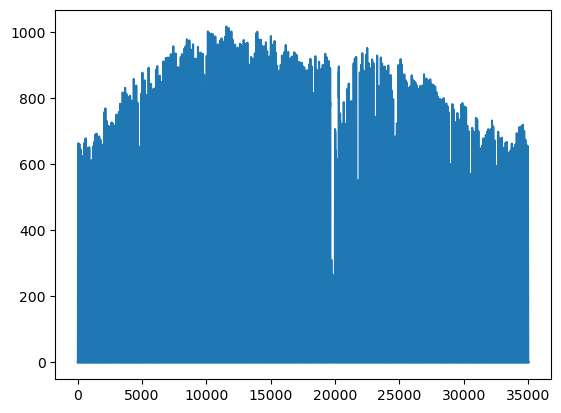

In [ ]:
target = workingDf['GHI']
target.plot()
plt.show()

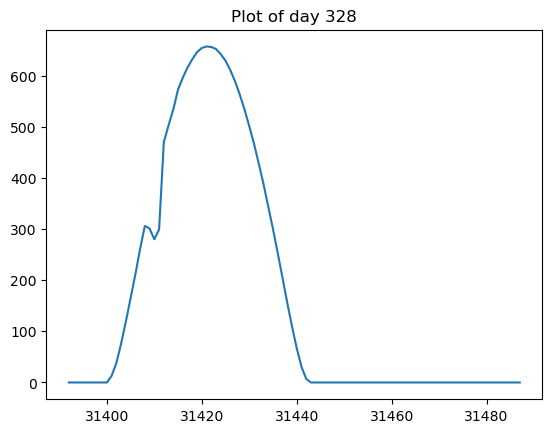

In [ ]:
random_day = random.randint(1, 365)
target = workingDf['GHI'][(random_day-1)*96:(random_day*96)]
target.plot()
plt.title(str(f"Plot of day {random_day}"))
plt.show()

In [ ]:
scaler = MinMaxScaler()
df_normalized = pd.DataFrame(scaler.fit_transform(workingDf), columns=workingDf.columns)
df_normalized.head(10)                     # this normalizes the data in between range [0, 1]

,Temperature,Dew Point,Wind Speed,Relative Humidity,Pressure,Precipitable Water,Wind Direction,GHI
0,0.169065,0.324921,0.21,0.454907,0.818182,0.118421,0.013889,0.0
1,0.169065,0.324921,0.21,0.454907,0.818182,0.118421,0.013889,0.0
2,0.169065,0.324921,0.20,0.454907,0.818182,0.131579,0.016667,0.0
3,0.169065,0.340694,0.20,0.480193,0.818182,0.131579,0.019444,0.0
4,0.169065,0.340694,0.20,0.480193,0.818182,0.131579,0.022222,0.0
5,0.172662,0.340694,0.20,0.475858,0.818182,0.144737,0.025000,0.0
6,0.172662,0.340694,0.19,0.476580,0.848485,0.144737,0.025000,0.0
7,0.176259,0.350158,0.19,0.485250,0.848485,0.144737,0.027778,0.0
8,0.179856,0.350158,0.19,0.480915,0.848485,0.144737,0.027778,0.0
9,0.194245,0.350158,0.18,0.463817,0.848485,0.144737,0.025000,0.0


In [ ]:
per_day_readings = 4 * 24                  # readings in one hour x total number of hours in a day
days = 3                                   # this variable defines our window length
window_length = days * per_day_readings    # we want our model to look back at the data of 3 days
horizon = 1                                # and then predict the next 15th minute reading

In [ ]:
df = df_normalized.values                  # converting dataframe to numpy arrays
stride = 1
x = []
y = []
for i in tqdm(range(0, len(df) - window_length, stride)):
    x.append(df[i:window_length+i, : ])    # GHI included but its past values only
    y.append(df[window_length+i,-1])       # next GHI value as our target which is to be predicted by the model

  0%|          | 0/34752 [00:00<?, ?it/s]

In [ ]:
x = np.array(x)                            # converting our features to numpy array
y = np.array(y)                            # converting our target to numpy array
print(x.shape)                             # printing our total feature data's shape
print(y.shape)                             # printing our target data's shape

(34752, 288, 8)
(34752,)


In [ ]:
x[45]                                      # checking if our windowing is correct or not

array([[0.43165468, 0.52996845, 0.38      , ..., 0.15789474, 0.73055556,
        0.25834971],
       [0.41726619, 0.52996845, 0.35      , ..., 0.15789474, 0.73055556,
        0.21021611],
       [0.39928058, 0.57097792, 0.32      , ..., 0.15789474, 0.73055556,
        0.16601179],
       ...,
       [0.49640288, 0.47634069, 0.36      , ..., 0.19736842, 0.675     ,
        0.30844794],
       [0.48920863, 0.51104101, 0.36      , ..., 0.19736842, 0.67777778,
        0.27013752],
       [0.48201439, 0.51104101, 0.36      , ..., 0.21052632, 0.68333333,
        0.11198428]])

In [ ]:
y[44]                                      # our windowing is correct as this previous output is now a part of our next input

0.11198428290766207

In [ ]:
# splitting our dataset into two parts one will be training set and the other will be testing set
# Lets store last 5 days as our test set
testing_days = 10
x_train = x[:-per_day_readings*testing_days]
y_train = y[:-per_day_readings*testing_days]
x_test  = x[len(y) - per_day_readings*testing_days:]
y_test  = y[len(y) - per_day_readings*testing_days:]
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(33792, 288, 8)
(33792,)
(960, 288, 8)
(960,)


In [ ]:
set_epochs = 500

In [ ]:
# Define a function to print layer names and activations
def print_layer_activations(model):
    for layer in model.layers:
        print(f"Layer: {layer.name} - Activation: {layer.activation}")

# RNN model

In [ ]:
# RNN Model  ( paper is using 6 features that's why its parameters is 4609 )
modelRNN = tf.keras.Sequential([
    keras.layers.SimpleRNN(64, input_shape=(288, 8), return_sequences=False),
    keras.layers.Dense(1, activation="sigmoid")
])
# Define the learning rate
learning_rate = 0.001

# Compile the model with the optimizer and learning rate
modelRNN.compile(loss='mae',
              optimizer=tf.keras.optimizers.AdamW(learning_rate=learning_rate),
              metrics=[tf.keras.metrics.RootMeanSquaredError()])

modelRNN.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 64)                4672      
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 4,737
Trainable params: 4,737
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Print layer names and activations
print_layer_activations(modelRNN)

Layer: simple_rnn - Activation: <function tanh at 0x7975e4974550>
Layer: dense - Activation: <function sigmoid at 0x7975e4974700>


# GRU model

In [ ]:
# GRU Model
modelGRU = tf.keras.Sequential([
    keras.layers.GRU(32, input_shape=(288, 8), return_sequences=True),
    keras.layers.GRU(32, return_sequences=False),
    keras.layers.Dense(1, activation="sigmoid")
])
# Define the learning rate
learning_rate = 0.001

# Compile the model with the optimizer and learning rate
modelGRU.compile(loss='mae',
              optimizer=tf.keras.optimizers.AdamW(learning_rate=learning_rate),
              metrics=[tf.keras.metrics.RootMeanSquaredError()])

modelGRU.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 288, 32)           4032      
                                                                 
 gru_1 (GRU)                 (None, 32)                6336      
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 10,401
Trainable params: 10,401
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Print layer names and activations
print_layer_activations(modelGRU)

Layer: gru - Activation: <function tanh at 0x7975e4974550>
Layer: gru_1 - Activation: <function tanh at 0x7975e4974550>
Layer: dense_1 - Activation: <function sigmoid at 0x7975e4974700>


# LSTM model

In [ ]:
# LSTM Model
modelLSTM = tf.keras.Sequential([
    keras.layers.LSTM(64, input_shape=(288, 8), return_sequences=True),
    keras.layers.LSTM(64, return_sequences=False),
    keras.layers.Dense(1, activation="sigmoid")
])
# Define the learning rate
learning_rate = 0.001

# Compile the model with the optimizer and learning rate
modelLSTM.compile(loss='mae',
              optimizer=tf.keras.optimizers.AdamW(learning_rate=learning_rate),
              metrics=[tf.keras.metrics.RootMeanSquaredError()])

modelLSTM.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 288, 64)           18688     
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 51,777
Trainable params: 51,777
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Print layer names and activations
print_layer_activations(modelLSTM)

Layer: lstm - Activation: <function tanh at 0x7975e4974550>
Layer: lstm_1 - Activation: <function tanh at 0x7975e4974550>
Layer: dense_2 - Activation: <function sigmoid at 0x7975e4974700>


# TCN model

In [ ]:
# TCN Model
modelTCN   = keras.models.Sequential([
              TCN(input_shape=(288, 8),
              kernel_size=15,
              nb_filters=15,
              dilations=[1, 2, 4, 8],
              padding='causal',
              activation='relu',
              return_sequences=False,
              nb_stacks=2,
              use_skip_connections=False,
              use_batch_norm=True
              ),
              keras.layers.Dense(1, activation="sigmoid")])

# Define the learning rate
learning_rate = 0.01

# Compile the model with the optimizer and learning rate
modelTCN.compile(loss='mae',
              optimizer=tf.keras.optimizers.AdamW(learning_rate=learning_rate, weight_decay = 0.001),
              metrics=[tf.keras.metrics.RootMeanSquaredError()])

modelTCN.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 tcn (TCN)                   (None, 15)                53760     
                                                                 
 dense_3 (Dense)             (None, 1)                 16        
                                                                 
Total params: 53,776
Trainable params: 53,296
Non-trainable params: 480
_________________________________________________________________


In [ ]:
print("Layer: TCN - Activation: ReLU")
print("Layer: Dense - Activation: sigmoid")

Layer: TCN - Activation: ReLU
Layer: Dense - Activation: sigmoid


In [ ]:
time1 = t.time()
print('Train...')
epochs = set_epochs
historyRNN = modelRNN.fit(x_train, y_train,
                    epochs=epochs,
                    verbose=1, batch_size=8192)
timeRNN = t.time() - time1
print(f"Total time to train {epochs} of RNN model is {timeRNN}")

Train...
Epoch 1/500
5/5 [==============================] - 6s 226ms/step - loss: 0.3163 - root_mean_squared_error: 0.3525
Epoch 2/500
5/5 [==============================] - 1s 224ms/step - loss: 0.2212 - root_mean_squared_error: 0.3085
Epoch 3/500
5/5 [==============================] - 1s 235ms/step - loss: 0.2013 - root_mean_squared_error: 0.3014
Epoch 4/500
5/5 [==============================] - 1s 218ms/step - loss: 0.1686 - root_mean_squared_error: 0.2266
Epoch 5/500
5/5 [==============================] - 1s 206ms/step - loss: 0.1197 - root_mean_squared_error: 0.1685
Epoch 6/500
5/5 [==============================] - 1s 220ms/step - loss: 0.0948 - root_mean_squared_error: 0.1419
Epoch 7/500
5/5 [==============================] - 1s 247ms/step - loss: 0.0844 - root_mean_squared_error: 0.1322
Epoch 8/500
5/5 [==============================] - 1s 231ms/step - loss: 0.0768 - root_mean_squared_error: 0.1122
Epoch 9/500
5/5 [==============================] - 1s 233ms/step - loss: 0.0706

In [ ]:
time1 = t.time()
print('Train...')
epochs = set_epochs
historyGRU = modelGRU.fit(x_train, y_train,
                    epochs=epochs,
                    verbose=1, batch_size=8192)
timeGRU = t.time() - time1
print(f"Total time to train {epochs} of GRU model is {timeGRU}")

Train...
Epoch 1/500
5/5 [==============================] - 6s 235ms/step - loss: 0.3365 - root_mean_squared_error: 0.3622
Epoch 2/500
5/5 [==============================] - 1s 235ms/step - loss: 0.2913 - root_mean_squared_error: 0.3151
Epoch 3/500
5/5 [==============================] - 1s 234ms/step - loss: 0.2578 - root_mean_squared_error: 0.2974
Epoch 4/500
5/5 [==============================] - 1s 236ms/step - loss: 0.2357 - root_mean_squared_error: 0.3049
Epoch 5/500
5/5 [==============================] - 1s 230ms/step - loss: 0.2241 - root_mean_squared_error: 0.3231
Epoch 6/500
5/5 [==============================] - 1s 234ms/step - loss: 0.2197 - root_mean_squared_error: 0.3383
Epoch 7/500
5/5 [==============================] - 1s 236ms/step - loss: 0.2181 - root_mean_squared_error: 0.3461
Epoch 8/500
5/5 [==============================] - 1s 236ms/step - loss: 0.2169 - root_mean_squared_error: 0.3481
Epoch 9/500
5/5 [==============================] - 1s 236ms/step - loss: 0.2150

In [ ]:
time1 = t.time()
print('Train...')
epochs = set_epochs
historyLSTM = modelLSTM.fit(x_train, y_train,
                    epochs=epochs,
                    verbose=1, batch_size=8192)
timeLSTM = t.time() - time1
print(f"Total time to train {epochs} of LSTM model is {timeLSTM}")

Train...
Epoch 1/500
5/5 [==============================] - 5s 323ms/step - loss: 0.3433 - root_mean_squared_error: 0.3721
Epoch 2/500
5/5 [==============================] - 2s 323ms/step - loss: 0.2477 - root_mean_squared_error: 0.3016
Epoch 3/500
5/5 [==============================] - 2s 329ms/step - loss: 0.2210 - root_mean_squared_error: 0.3502
Epoch 4/500
5/5 [==============================] - 2s 330ms/step - loss: 0.2206 - root_mean_squared_error: 0.3650
Epoch 5/500
5/5 [==============================] - 2s 322ms/step - loss: 0.2207 - root_mean_squared_error: 0.3680
Epoch 6/500
5/5 [==============================] - 2s 321ms/step - loss: 0.2206 - root_mean_squared_error: 0.3689
Epoch 7/500
5/5 [==============================] - 2s 326ms/step - loss: 0.2206 - root_mean_squared_error: 0.3688
Epoch 8/500
5/5 [==============================] - 2s 325ms/step - loss: 0.2204 - root_mean_squared_error: 0.3686
Epoch 9/500
5/5 [==============================] - 2s 322ms/step - loss: 0.2202

In [ ]:
time1 = t.time()
print('Train...')
epochs = set_epochs
historyTCN = modelTCN.fit(x_train, y_train,
                    epochs=epochs,
                    verbose=1, batch_size=8192)
timeTCN = t.time() - time1
print(f"Total time to train {epochs} of TCN model is {timeTCN}")

Train...
Epoch 1/500
5/5 [==============================] - 26s 859ms/step - loss: 0.2997 - root_mean_squared_error: 0.4492
Epoch 2/500
5/5 [==============================] - 3s 646ms/step - loss: 0.1191 - root_mean_squared_error: 0.2099
Epoch 3/500
5/5 [==============================] - 3s 645ms/step - loss: 0.0993 - root_mean_squared_error: 0.1808
Epoch 4/500
5/5 [==============================] - 3s 647ms/step - loss: 0.0695 - root_mean_squared_error: 0.1321
Epoch 5/500
5/5 [==============================] - 3s 646ms/step - loss: 0.0497 - root_mean_squared_error: 0.0956
Epoch 6/500
5/5 [==============================] - 3s 647ms/step - loss: 0.0443 - root_mean_squared_error: 0.0866
Epoch 7/500
5/5 [==============================] - 3s 646ms/step - loss: 0.0377 - root_mean_squared_error: 0.0741
Epoch 8/500
5/5 [==============================] - 3s 644ms/step - loss: 0.0321 - root_mean_squared_error: 0.0666
Epoch 9/500
5/5 [==============================] - 3s 645ms/step - loss: 0.031

In [ ]:
# Extract the history of loss and metric result from the history object

#RNN
loss_history_rnn = historyRNN.history['loss']
r2_history_rnn = historyRNN.history['root_mean_squared_error']

#GRU
loss_history_gru = historyGRU.history['loss']
r2_history_gru = historyGRU.history['root_mean_squared_error']

#LSTM
loss_history_lstm = historyLSTM.history['loss']
r2_history_lstm = historyLSTM.history['root_mean_squared_error']

#TCN
loss_history_tcn = historyTCN.history['loss']
r2_history_tcn = historyTCN.history['root_mean_squared_error']

# RNN loss and Metric Plot

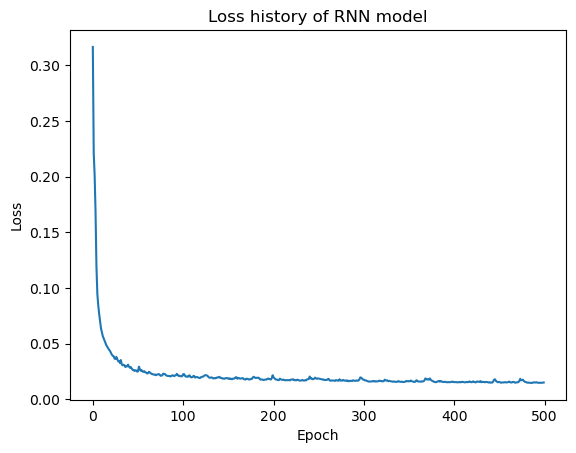

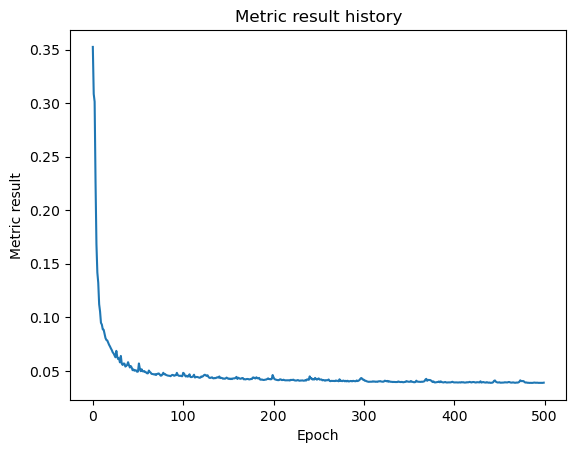

In [ ]:
# Plot the history of loss of RNN
plt.plot(loss_history_rnn)
plt.title('Loss history of RNN model')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# Plot the history of metric result of RNN
plt.plot(r2_history_rnn)
plt.title('Metric result history')
plt.xlabel('Epoch')
plt.ylabel('Metric result')
plt.show()

# GRU loss and Metric Plot

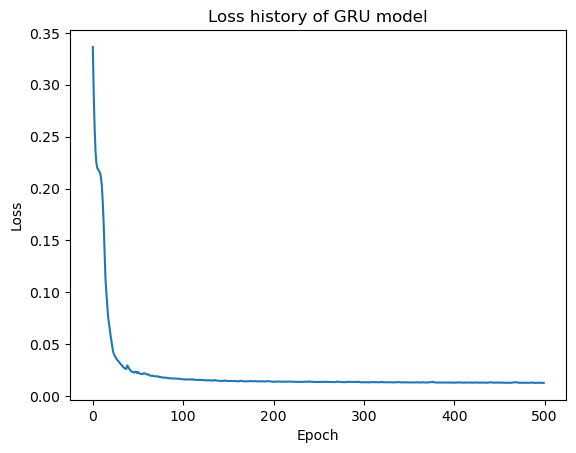

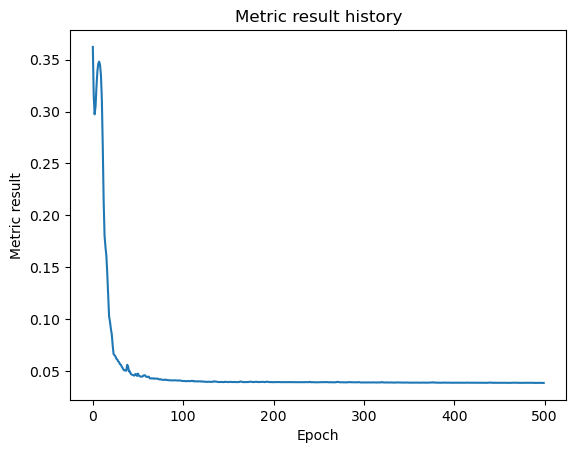

In [ ]:
# Plot the history of loss of GRU
plt.plot(loss_history_gru)
plt.title('Loss history of GRU model')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# Plot the history of metric result of GRU
plt.plot(r2_history_gru)
plt.title('Metric result history')
plt.xlabel('Epoch')
plt.ylabel('Metric result')
plt.show()

# LSTM loss and Metric Plot

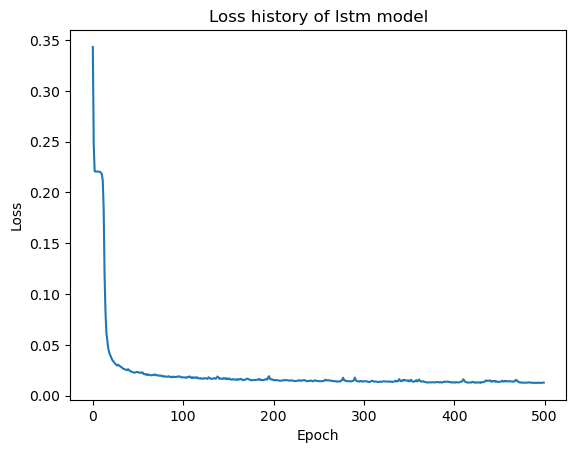

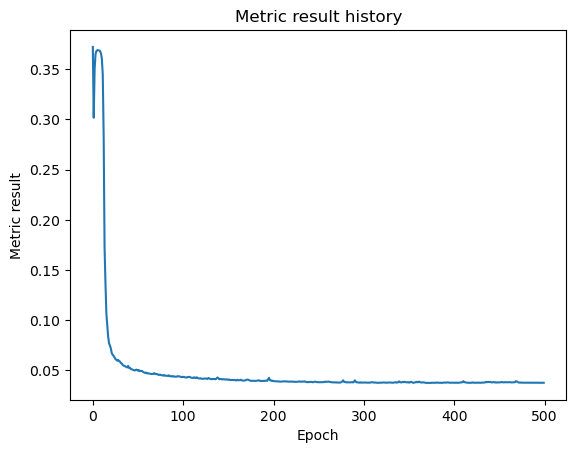

In [ ]:
# Plot the history of loss of LSTM
plt.plot(loss_history_lstm)
plt.title('Loss history of lstm model')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# Plot the history of metric result of LSTM
plt.plot(r2_history_lstm)
plt.title('Metric result history')
plt.xlabel('Epoch')
plt.ylabel('Metric result')
plt.show()

# TCN loss and Metric Plot

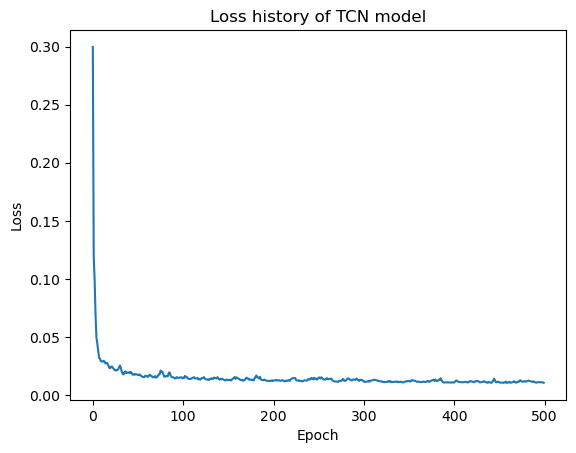

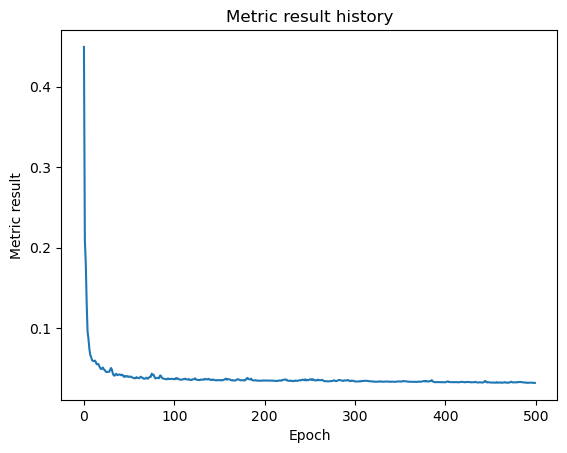

In [ ]:
# Plot the history of loss of LSTM
plt.plot(loss_history_tcn)
plt.title('Loss history of TCN model')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# Plot the history of metric result of LSTM
plt.plot(r2_history_tcn)
plt.title('Metric result history')
plt.xlabel('Epoch')
plt.ylabel('Metric result')
plt.show()

In [ ]:
# RNN prediction
t1 = t.time()
predictionRNN = modelRNN.predict(x_test)
inferRNN = t.time() - t1

# GRU prediction
t1 = t.time()
predictionGRU = modelGRU.predict(x_test)
inferGRU = t.time() - t1

# LSTM prediction
t1 = t.time()
predictionLSTM = modelLSTM.predict(x_test)
inferLSTM = t.time() - t1

# TCN prediction
t1 = t.time()
predictionTCN = modelTCN.predict(x_test)
inferTCN = t.time() - t1

30/30 [==============================] - 1s 4ms/step


In [ ]:
# Update the metric with the true values and predicted values
MSE_RNN = mean_squared_error(y_test, predictionRNN.reshape(predictionRNN.shape[0])  )
print("Root Mean Squared Error (RNN):", round(math.sqrt(MSE_RNN), 6))

MSE_GRU = mean_squared_error(y_test, predictionGRU.reshape(predictionGRU.shape[0])  )
print("Root Mean Squared Error (GRU):", round(math.sqrt(MSE_GRU), 6))

MSE_LSTM = mean_squared_error(y_test, predictionLSTM.reshape(predictionLSTM.shape[0]))
print("Root Mean Squared Error (LSTM):", round(math.sqrt(MSE_LSTM), 6))

MSE_TCN = mean_squared_error(y_test, predictionTCN.reshape(predictionTCN.shape[0])  )
print("Root Mean Squared Error (TCN):", round(math.sqrt(MSE_TCN), 6))

Root Mean Squared Error (RNN): 0.022175
Root Mean Squared Error (GRU): 0.021371
Root Mean Squared Error (LSTM): 0.020051
Root Mean Squared Error (TCN): 0.021519


In [ ]:
print("R2 accuracy of RNN model is :",round(r2_score(y_test, predictionRNN.reshape(predictionRNN.shape[0])), 6)   )

print("R2 accuracy of GRU model is :",round(r2_score(y_test, predictionGRU.reshape(predictionGRU.shape[0])), 6)   )

print("R2 accuracy of LSTM model is :",round(r2_score(y_test, predictionLSTM.reshape(predictionLSTM.shape[0])), 6))

print("R2 accuracy of TCN model is :",round(r2_score(y_test, predictionTCN.reshape(predictionTCN.shape[0])), 6)   )

R2 accuracy of RNN model is : 0.991935
R2 accuracy of GRU model is : 0.992509
R2 accuracy of LSTM model is : 0.993406
R2 accuracy of TCN model is : 0.992405


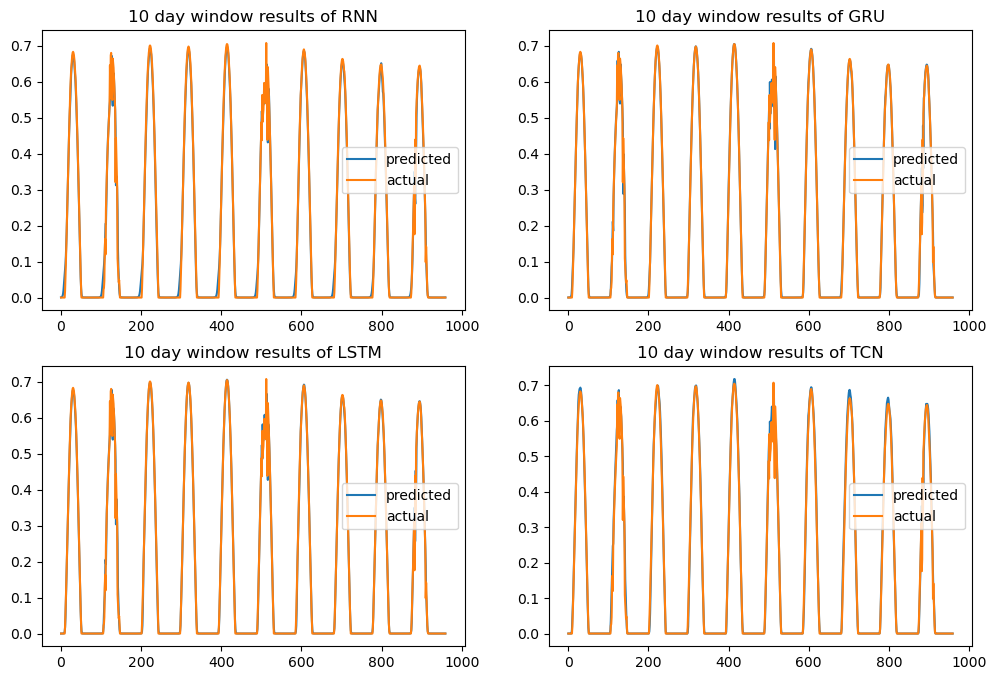

In [ ]:
# Making the figure size bigger
plt.figure(figsize=(12, 8))

# RNN's prediction plot
plt.subplot(2,2,1)
plt.plot(predictionRNN)
plt.plot(y_test)
plt.title(f'{testing_days} day window results of RNN')
plt.legend(['predicted', 'actual'])

# GRU's prediction plot
plt.subplot(2,2,2)
plt.plot(predictionGRU)
plt.plot(y_test)
plt.title(f'{testing_days} day window results of GRU')
plt.legend(['predicted', 'actual'])

# LSTM's prediction plot
plt.subplot(2,2,3)
plt.plot(predictionLSTM)
plt.plot(y_test)
plt.title(f'{testing_days} day window results of LSTM')
plt.legend(['predicted', 'actual'])

# TCN's prediction plot
plt.subplot(2,2,4)
plt.plot(predictionTCN)
plt.plot(y_test)
plt.title(f'{testing_days} day window results of TCN')
plt.legend(['predicted', 'actual'])
plt.savefig('/kaggle/working/PlotImg.png')
plt.show()

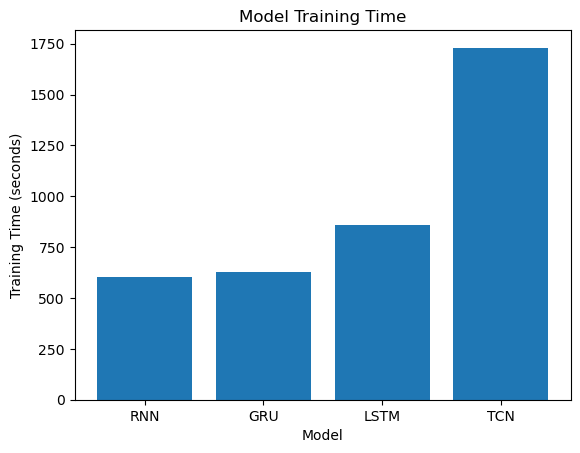

In [ ]:
models = ['RNN', 'GRU', 'LSTM','TCN']
timeTrain = [timeRNN, timeGRU, timeLSTM, timeTCN]
timeInfer = [inferRNN, inferGRU, inferLSTM, inferTCN]

plt.bar(models, timeTrain)
plt.xlabel('Model')
plt.ylabel('Training Time (seconds)')
plt.title('Model Training Time')
plt.savefig('/kaggle/working/trainingImg.png')
plt.show()

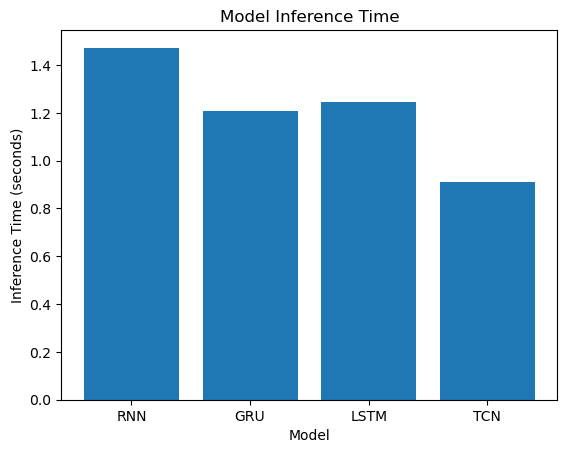

In [ ]:
plt.bar(models, timeInfer)
plt.xlabel('Model')
plt.ylabel('Inference Time (seconds)')
plt.title('Model Inference Time')
plt.savefig('/kaggle/working/InferingImg.png')
plt.show()